## SSAC - Exploration 10 - Image Segmentation 

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

---
## Step 1. 인물모드 직접 해 보기

In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_man.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2388, 2388, 3)


In [9]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [10]:
# define model and download & load pretrained weight
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2388, 2388, 3) (513, 513, 3) 15


image source : https://unsplash.com/photos/PsMFN3UeXLI

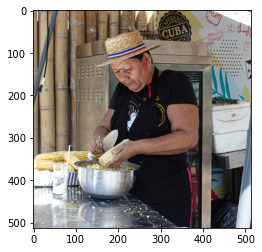

In [17]:
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

In [11]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

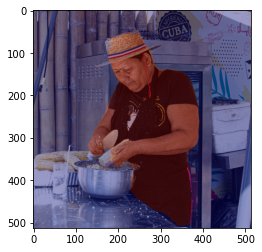

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

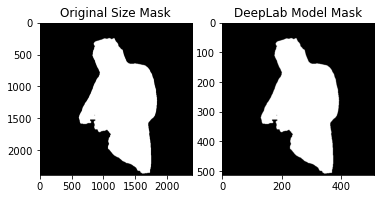

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

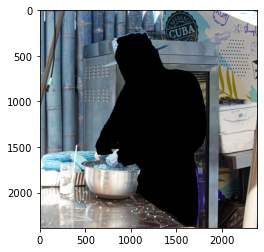

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

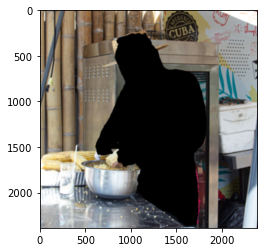

In [10]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

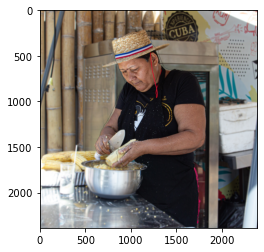

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
save_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_man_concat.jpg' 
cv2.imwrite(save_dir, img_concat)

True

---
# cat

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_cat1.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2770, 2770, 3)


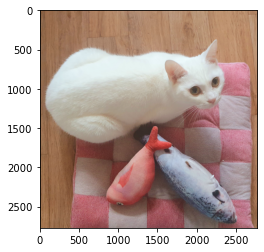

In [32]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

In [33]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2770, 2770, 3) (513, 513, 3) 8


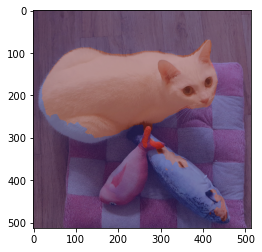

In [34]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

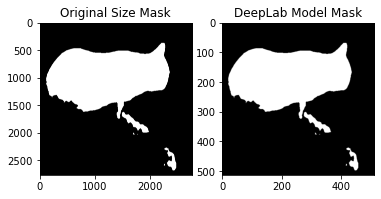

In [35]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

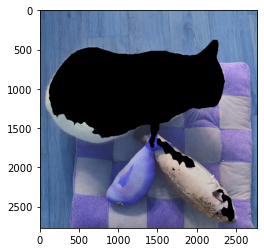

In [36]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

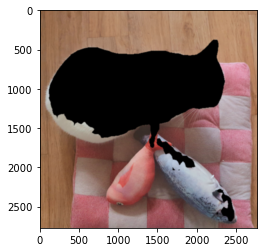

In [37]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

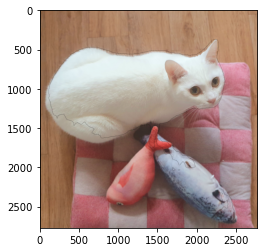

In [38]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [39]:
save_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_cat_concat.jpg' 
cv2.imwrite(save_dir, img_concat)

True

---
# overlay image

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_cat2.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(3000, 4496, 3)


image source: https://unsplash.com/photos/uQM21GP6CGg

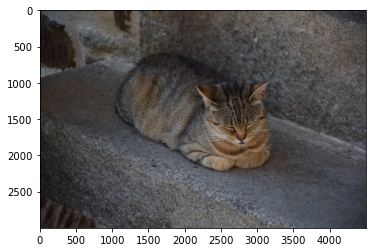

In [6]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

In [7]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_back.jpg'
img_back = cv2.imread(img_path) 
print (img_back.shape)

(3264, 4896, 3)


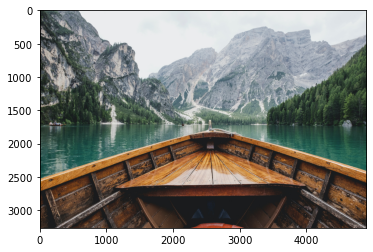

In [8]:
plt.imshow(cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB))

In [13]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(3000, 4496, 3) (342, 513, 3) 8


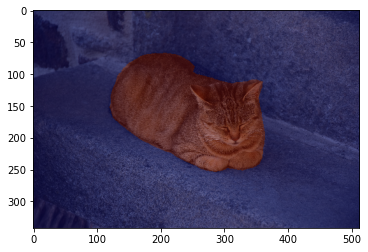

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

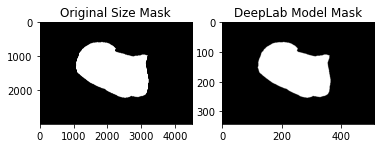

In [15]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [17]:
height, width = img_back.shape[:2]
center = (width//2, height//3*2)

In [25]:
mixed = cv2.seamlessClone(src=img_orig, dst=img_back, mask=img_mask_up, p=center, flags=cv2.NORMAL_CLONE)

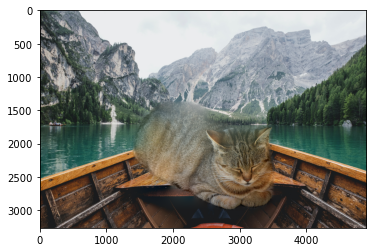

In [26]:
plt.imshow(cv2.cvtColor(mixed, cv2.COLOR_BGR2RGB))

In [27]:
save_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_cat_boat_mixed.jpg' 
cv2.imwrite(save_dir, mixed)

True

---
# Step 2. 사진에서 문제점 찾기

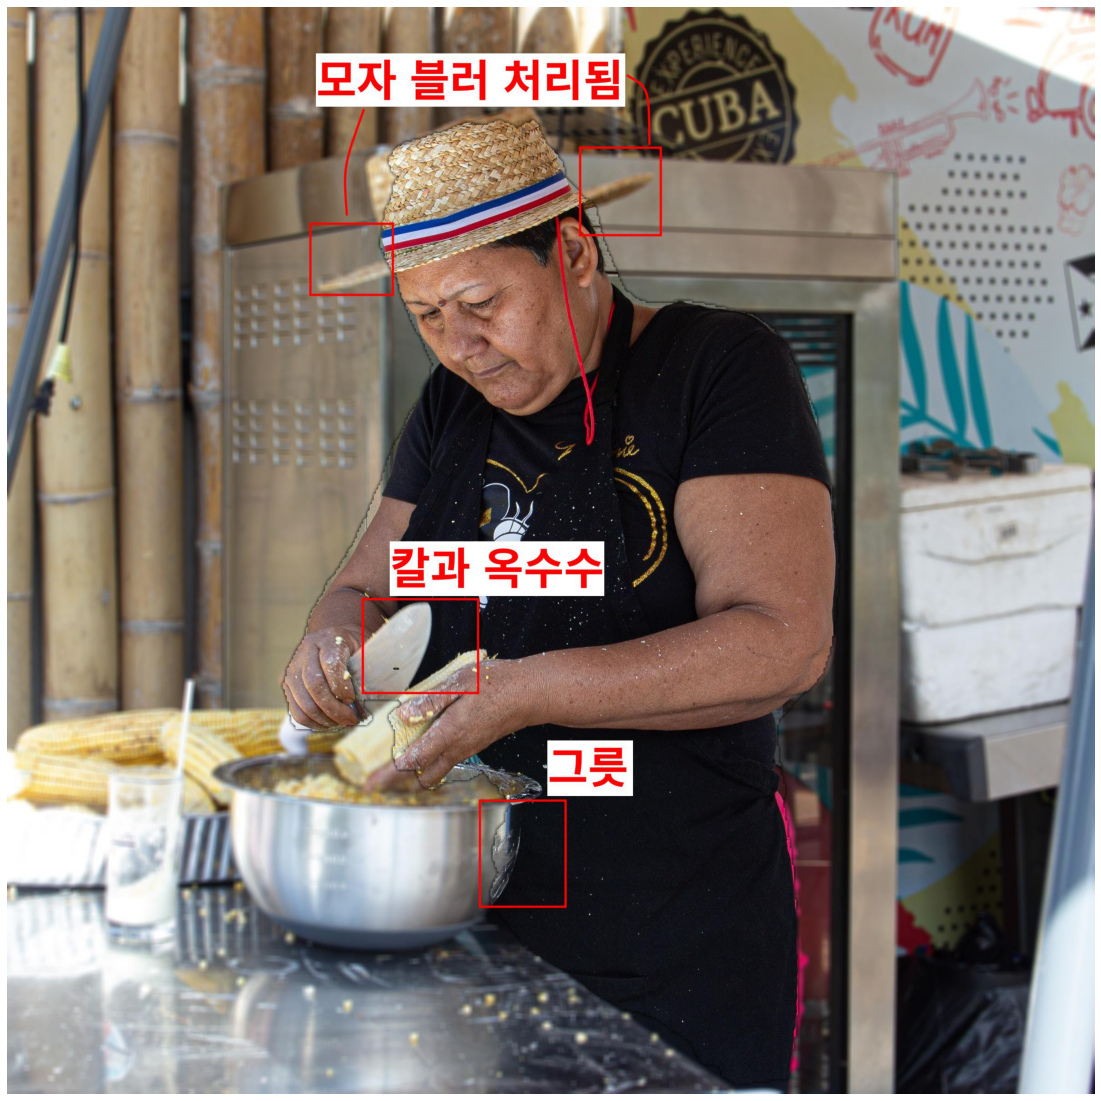

In [10]:
import matplotlib.image as img
plt.figure(figsize=(25, 20))
file_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_man_concat_nota.jpg'
img_nota = img.imread(file_path)
plt.axis('off')
plt.imshow(img_nota)

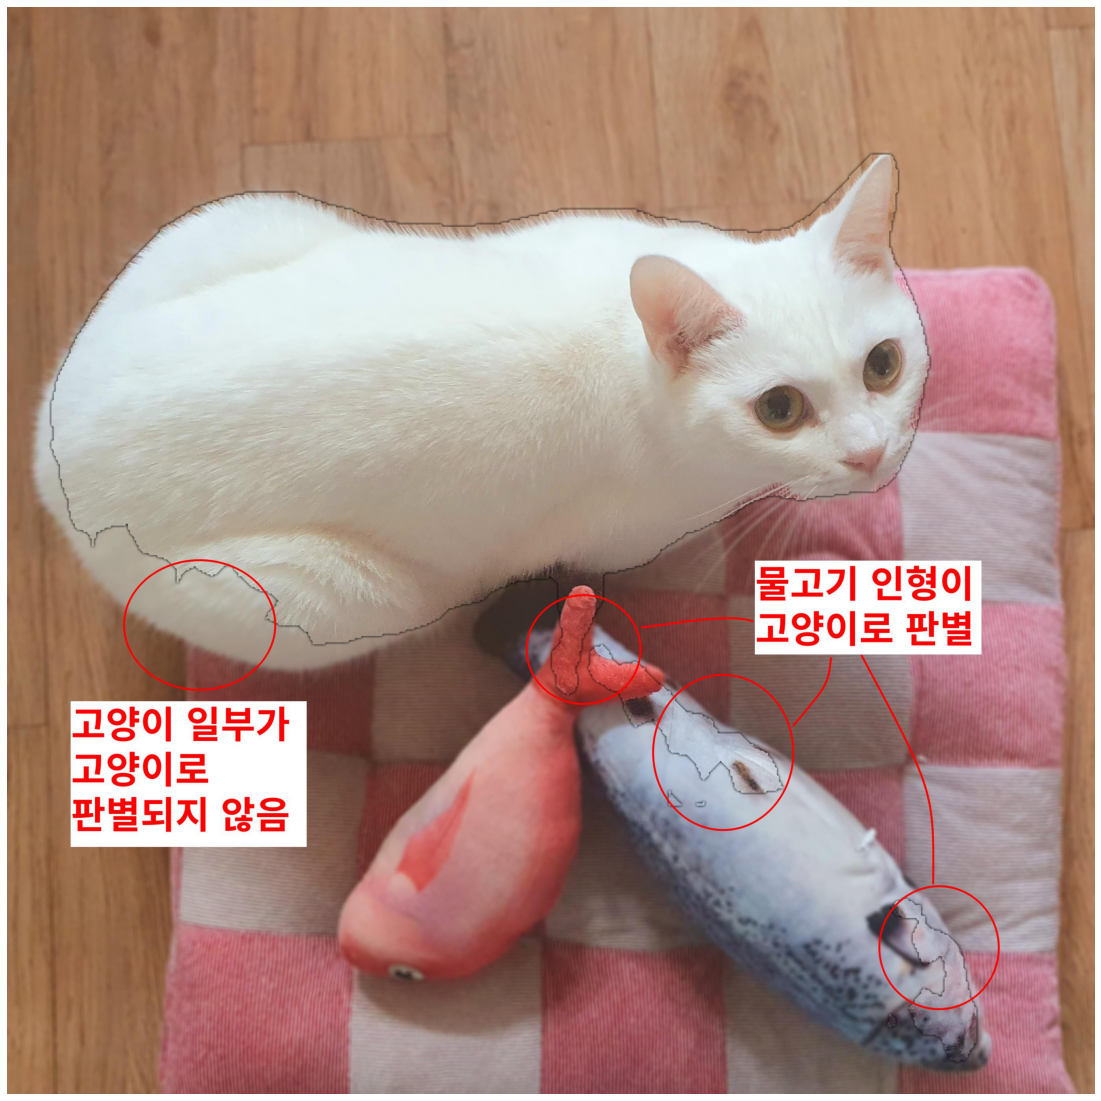

In [9]:
plt.figure(figsize=(25, 20))
file_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_cat_concat_nota.jpg'
img_nota = img.imread(file_path)
plt.axis('off')
plt.imshow(img_nota)

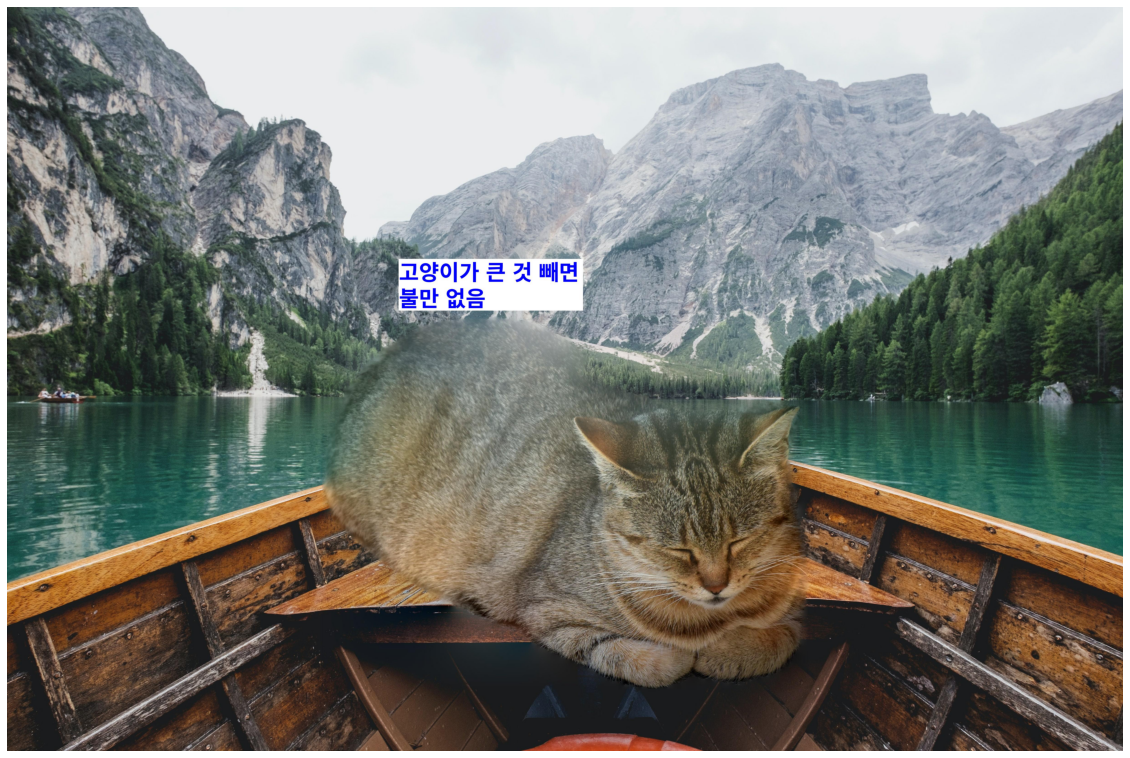

In [8]:
plt.figure(figsize=(20, 25))
file_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_cat_boat_mixed_nota.jpg'
img_nota = img.imread(file_path)
plt.axis('off')
plt.imshow(img_nota)

---
## Step 3. 해결 방법을 제안해 보기

1. 첫번째 인물 사진에서 생각해본 점   
+ 그릇이 제대로 구분되지 않았는데 그릇이 빛을 반사하는 재질이어서 사람 모습이 반사된 것 때문에 제대로 구분되지 않은 것 같다. 색상이 비슷하여 공간적인 위치 구분이 잘 되지 않은 것 같은데 픽셀간의 깊이를 잘 구분해 낼 수 있는 방법이 있으면 좀 더 잘 구분할 수 있지 않을까?   
+ 칼과 옥수수는 부분적으로 사람으로 인식된 부분이 있다. 이와 동시에 사람 손가락 일부분은 사람으로 인식되지 못했다. 옥수수는 손으로 들고 있고 손에 옥수수 파편이 묻어 있어 픽셀간의 깊이나 색상간의 차이가 비교적 적다고 해도 칼은 색상도 차이가 많이 나고 픽셀 깊이 상에서도 차이가 있을텐데 잘 구분하지 못한 이유를 잘 모르겠다.
+ 모자는 챙 부분이 인식되지 못했다. 옷이나 사람의 머리를 덮는 모자 부분과 달리 모자의 챙은 사람의 일반적인 형상에서 벗어나기 때문에 사람으로 인식되지 않는 것인가 싶다. 사진 상에서 표현되는 면적도 작은 편이라 판별이 잘 안된 것인가 유추해 본다. 
2. 두번째 고양이 사진에서 생각해본 점   
+ 고양이 옆에 있는 물고기 사진은 색상도 차이가 많이 나는데 고양이 일부분으로 인식한 반면 고양이의 엉덩이 부분이 고양이로 인식되지 않은 것이 신기하다. 특히 고등어 인형의 일부분이 고양이로 인식된 경우가 많았다. 억지로 이유를 생각해 보자면 고등어 인형의 점박이 부분이 고양이 무늬랑 비슷한 점이 있어서 부분적으로 고양이로 인식될수도 있겠다 싶다.
3. 세번째 고양이 사진에서 생각해본 점 : 배경의 차이    
+  segmentation에서 문제가 있었던 사진들과 문제가 없었던 세번째 고양이 사진을 보면 segemntation 실행한 사진에서 배경이 차이가 있었다. 세번째 고양이 사진에서는 배경이 평편한 돌 계단이고 공간적으로나 색상적으로다 일관된 배경이었다. 따라서 배경이 공간적이나 색상적으로 일관적이지 않을 때에도 물체를 잘 구분해낼 수 있는 방법이 있을까?   
4. 전반적인 문제점   
+ 블러 처리한 배경과 구분해낸 물체를 합쳤을 때 주변 선이 매끄럽지가 않다. 아마 리사이즈 해서 세그멘테이션 한 후에 이를 원래 사이즈로 확대하는 과정에서 segmentation경계가 불확실해진 것이 아닌가 싶다. 특히 blur 처리하면서 검은색으로 마스킹했던 부분의 경계 색이 경계밖의 색과 섞이면서 블러 처리 하지 않은 물체사진을 단순 겹쳤을 때 검은 윤곽선 처럼 만들어진 것이 아닐까.     
+ 세번째 고양이 사진에서는 cv2에서 제공하는 seamlessclone 메소드로 처리를 했는데 검은 색의 주변선이 보이지는 않지만 배경과 물체의 색이 섞이면서 주변부를 블러처리 한 것 같은 결과가 나왔다. 원본은 선명하면서 배경은 블러처리하고 주변부 윤곽선이 없게 합치는 방법은 뭐가 있을까.

5. 해결방법 고민   
+ 이미지 사이즈 복원에 대한 이해가 부족해서 이미지 사이즈를 줄였다가 원래대로 복원하는 것이 세그멘테이션의 픽셀 경계를 거칠게 만드는 것에 일조를 하는지 확실히 알 수가 없다. 검은 경계선은 블러 처리 후 블러 처리한 사진과 세그멘테이션 이전의 사진을 알파값을 조정하여 겹치면 검은 경계색이 두드러지는 것을 좀 줄일 수 있지 않을까? 아니면 seamlessclone 메소드로 합쳐보는 것도 한 방법이 될 수 있을 것 같다.   
+ 이해한 바로는 deeplab 모델은 segmentation map을 학습한다. 한장의 이미지에서 경계를 구분하다 보니 첫번째 인물 사진 처럼 사람 주변에서 사람을 반사하는 그릇이 사람으로 판별되는 결과가 나온 것이 아닐까. 그렇다면 노드에서 제시한 대로 segmentation map 외에 pixel depth map을 학습시키는 모델과 합쳐서 학습을 시키면 피쳐 하나가 더 늘어나는 격이 되어 물체 구분을 더 잘 할수 있지 않을까.
+ 학습 노드에서 pixel depth를 학습하기 위한 방법으로 적외선 센서, 두개의 카메라로 동시에 촬영한 후 물체의 위치변화에 따른 시야각을 구해 카메라로부터의 물체 거리를 계산하는 방법, 영상의 경우 프레임으로 짝을 지어 영상 프레임 간의 형상 변화에 따라 물체의 위치를 판별하도록 학습하는 방법 등이 제시되었는데, 다 처음 보는 내용이라 이러한 모델과 segmentation map을 학습하는 모델을 합치는 방법에 대해서는 아무런 아이디어가 떠오르지 않는다.   